In [3]:
import pandas as pd
import numpy as np
from io import StringIO
import re
from scipy.optimize import fsolve
from astropy import constants as const
import emcee
import corner
import matplotlib.pyplot as plt

In [4]:
from tools import *
%load_ext autoreload
%autoreload 2

First, we will generate our data (radial velocity values) using a simulation!

The radial velocity of a star in a binary system is given by:
$$v(t) = \kappa[cos(f+\omega)+e \cos\omega + v_0$$
where
$$\kappa =\dfrac{(2\pi G)^{1/3}m\sin I}{T^{1/3}(M+m)^{2/3}\sqrt{1-e^2}}$$

$$tan(f/2)= \sqrt{\dfrac{1+e}{1-e}}\tan(u/2)$$

$$u-e\sin u = \dfrac{2\pi}{T}(t-\tau)$$

#### insert descr. of parameters!!!!!!!!! ####

To generate values for the uncertainty, we want to determine what factors will influence the uncertainty value. We first looked for a correlation between radial velocity and uncertainty. Plotting the relationship between radial velocity and uncertainty for some sample systems, we get the following:

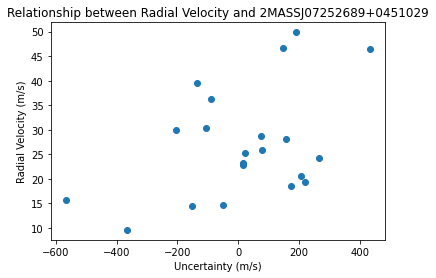

In [3]:
# selecting a random file from directory
all_files = list_files('data')
index = np.random.randint(0, len(all_files)-1)

plot_uncertainty_for_file(all_files[index])

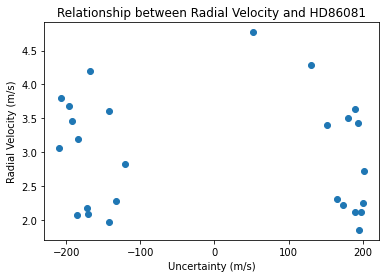

In [4]:
# selecting a random plot from directory
all_files = list_files('data')
index = np.random.randint(0, len(all_files))

plot_uncertainty_for_file(all_files[index])

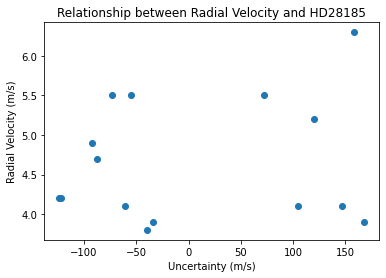

In [5]:
# selecting a random plot from directory
all_files = list_files('data')
index = np.random.randint(0, len(all_files))

plot_uncertainty_for_file(all_files[index])

From the sample plots, there doesn't really seem to be a clear correlation between radial velocity and uncertainty. We can also plot all radial velocity values and uncertainties across all datasets:

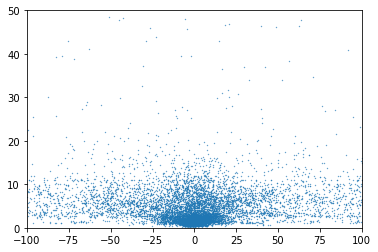

In [6]:
plot_uncertainty_correlation()

Since there really isn't an obvious correlation, we will assume that the value of radial velocity has no effect on the associated value of uncertainty. We will assume that the instrument used will uniquely determine the uncertainty. For purposes of the simulation, we will draw randomly from the distribution of uncertainties of a selected instrument. 

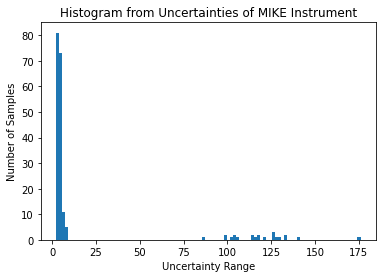

In [7]:
# selecting a random file from directory
all_files = list_files('data')
index = np.random.randint(0, len(all_files)-1)
# finding associated instrument 
instrument = get_instrument(all_files[index])

uncertainties = get_uncertainties_instrument(instrument)
plot_instrumental_uncertainty_hist(instrument, bins=100)

## BD -17 0063

In [3]:
bd_0063_files = find_files_for_star('BD -17 0063')
print(bd_0063_files)

['UID_0002247_RVC_001.tbl']


In [4]:
bd_0063 = BinarySystem(data=get_data('UID_0002247_RVC_001.tbl'))

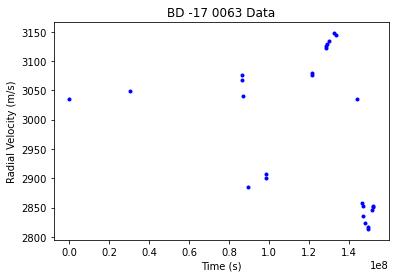

In [5]:
bd_0063.plot_data(title='BD -17 0063 Data')

In [6]:
bd_0063.run_mcmc(40000, 60)

  0%|          | 144/40000 [00:02<09:37, 68.97it/s]C:\Users\willp\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 40000/40000 [06:40<00:00, 99.92it/s] 


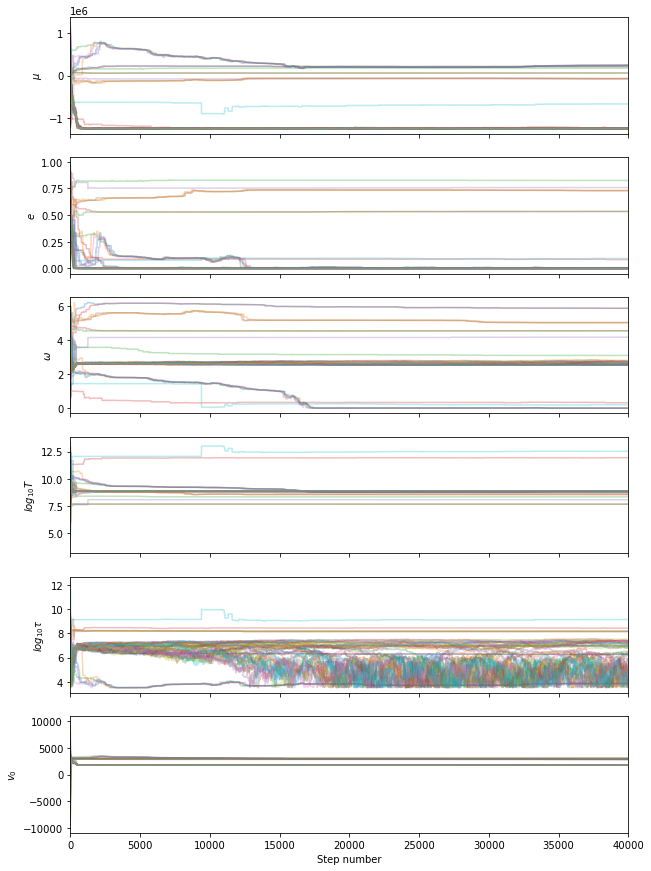

In [7]:
bd_0063.trace()

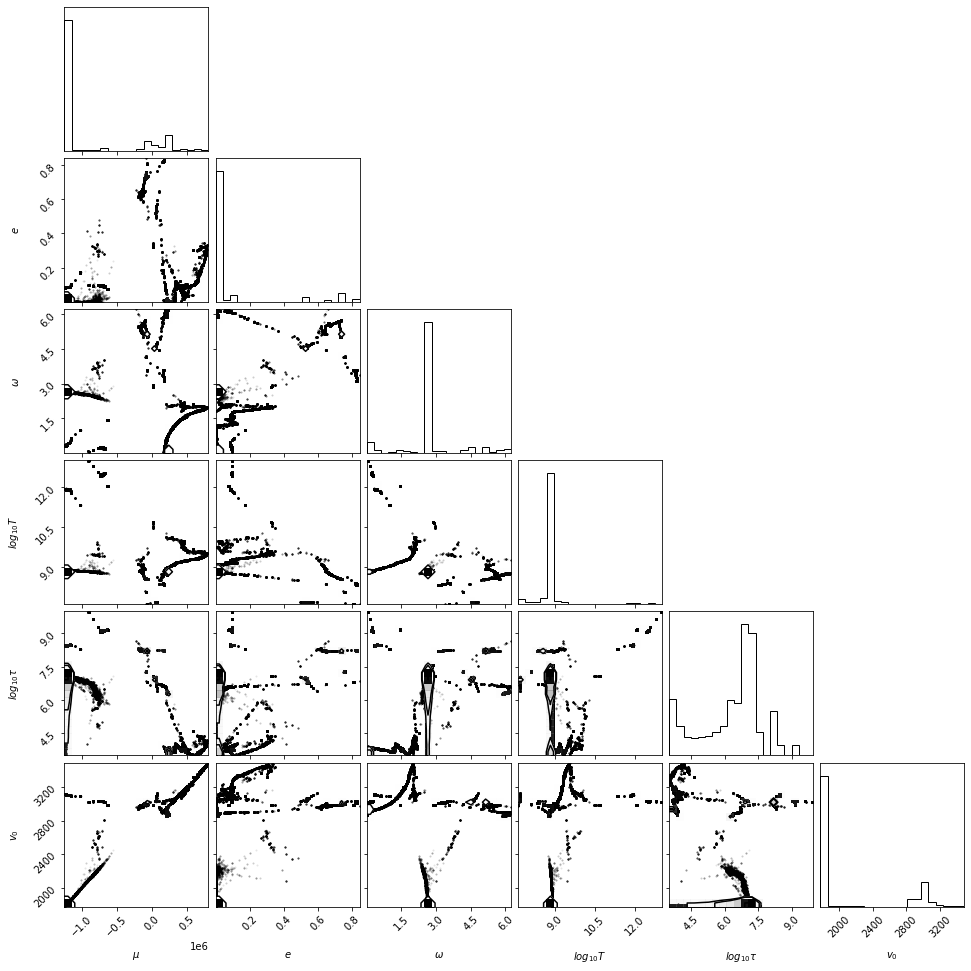

In [8]:
bd_0063.corner()

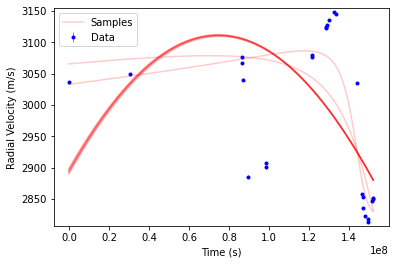

In [9]:
bd_0063.plot_samples(10)

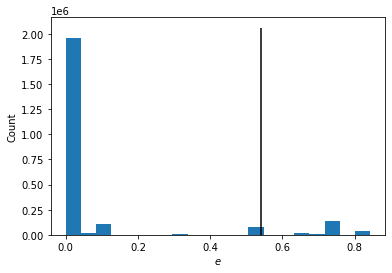

In [10]:
bd_0063.param_hist_plot(1, 20, actual_value=0.54)

## HD 129445

In [11]:
find_files_for_star('HD 129445')

['UID_0072203_RVC_001.tbl']

In [12]:
hd129445 = BinarySystem(data=get_data('UID_0072203_RVC_001.tbl'))

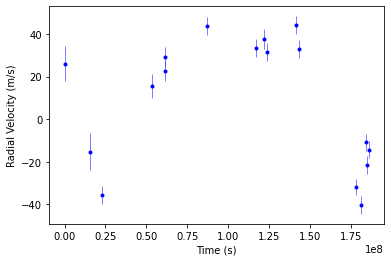

In [13]:
hd129445.plot_data()

In [14]:
hd129445.run_mcmc(40000, 60)

  9%|▉         | 3501/40000 [00:43<07:54, 76.99it/s]C:\Users\willp\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 40000/40000 [08:54<00:00, 74.77it/s] 


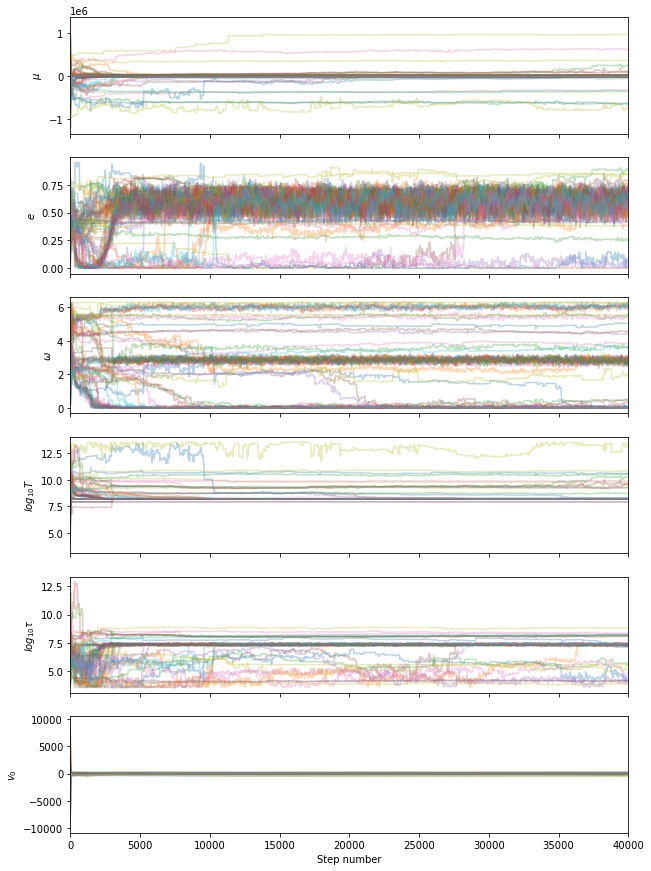

In [15]:
hd129445.trace()

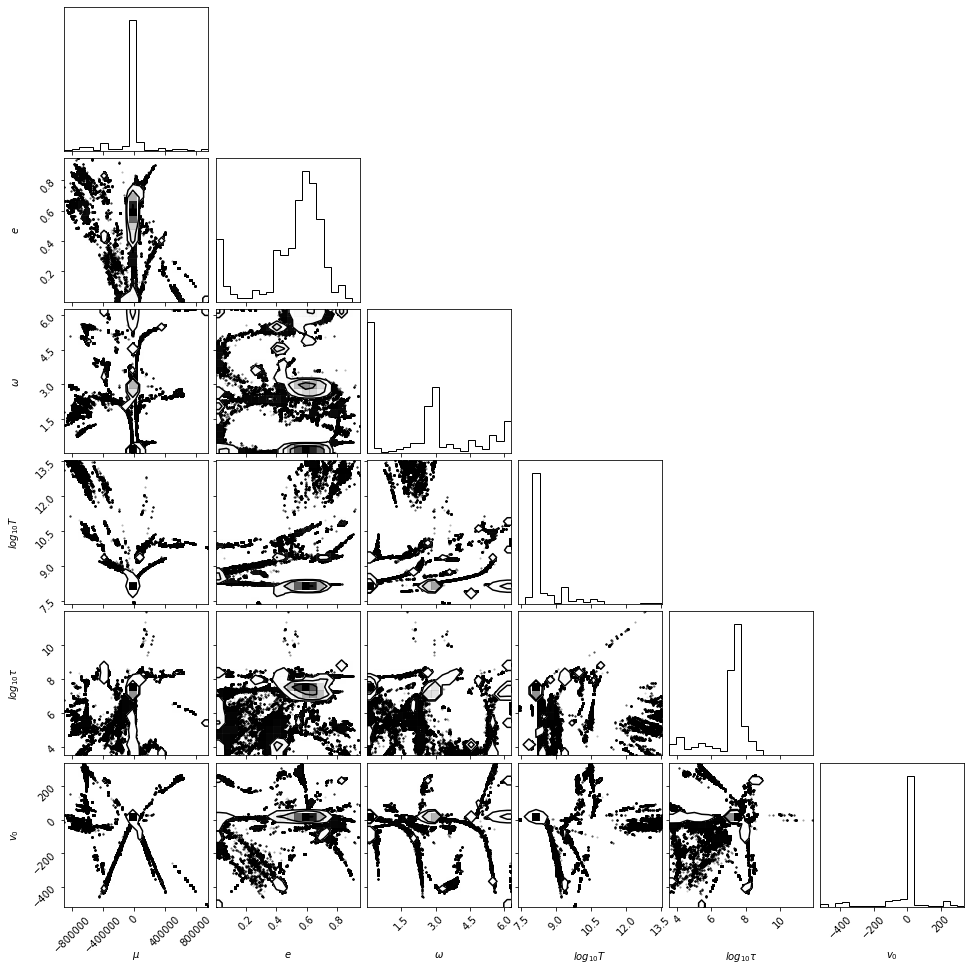

In [16]:
hd129445.corner(discard=500)

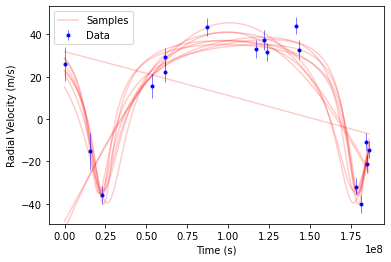

In [17]:
hd129445.plot_samples(10)

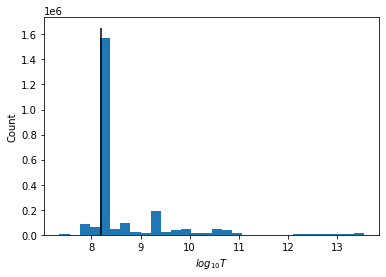

In [18]:
hd129445.param_hist_plot(3, 30, actual_value=[8.2])

## HD 136418

In [19]:
find_files_for_star('HD 136418')

['UID_0074961_RVC_001.tbl']

In [20]:
hd136418 = BinarySystem(data=get_data('UID_0074961_RVC_001.tbl'))

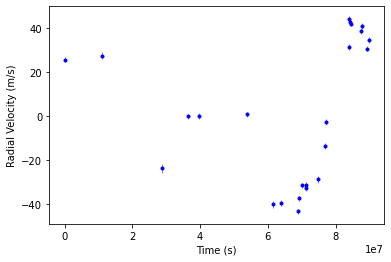

In [21]:
hd136418.plot_data()

In [22]:
hd136418.run_mcmc(40000, 60)

  1%|          | 496/40000 [00:06<07:39, 85.94it/s]C:\Users\willp\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 40000/40000 [10:35<00:00, 62.95it/s]


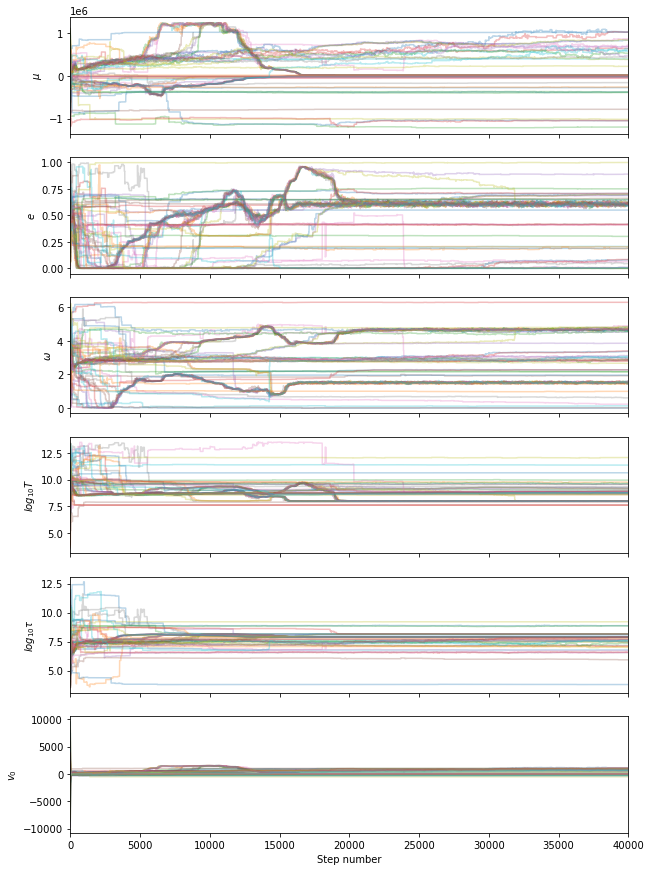

In [23]:
hd136418.trace()

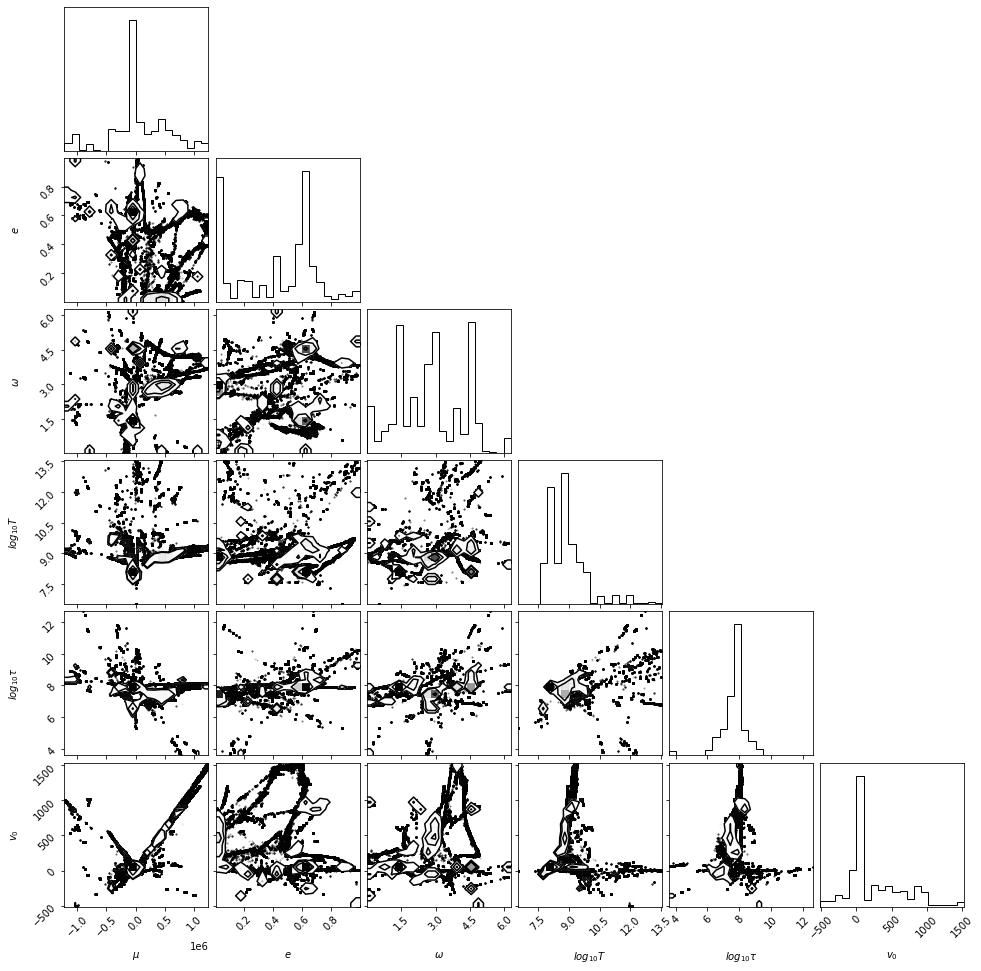

In [24]:
hd136418.corner()

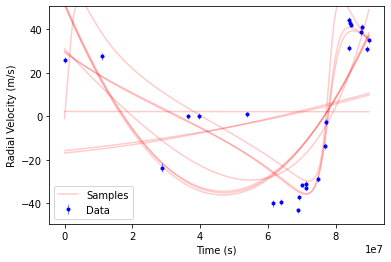

In [25]:
hd136418.plot_samples(10)

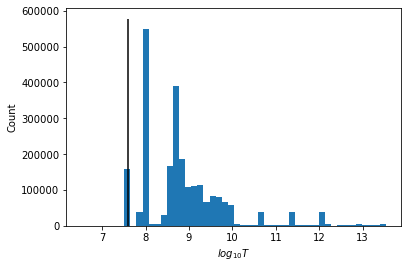

In [29]:
hd136418.param_hist_plot(3, 50, actual_value=7.6)

## $\mu=0$

In [43]:
parameters = [0]
parameters.append(np.random.uniform(0, 1))
parameters.append(np.random.uniform(0, np.pi/2))
parameters.append(10**np.random.uniform(3.516184928, 13.54019929)) # in seconds
parameters.append(10**np.random.uniform(3.516184928, np.log10(parameters[-1]))) # in seconds
parameters.append(np.random.choice(np.linspace(-9000, 9000, 10000))) # in m/s

no_planet = BinarySystem(parameters=parameters, num_points=25, tmax=5e8)

In [44]:
no_planet.truth()

array([ 0.00000000e+00,  6.11454809e-01,  1.25672793e+00,  1.23693726e+01,
        9.96205038e+00, -1.62106211e+03])

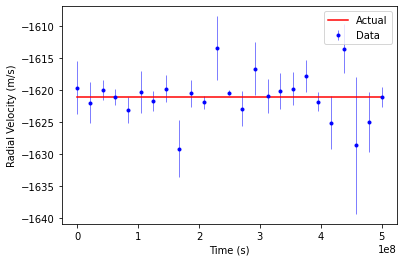

In [45]:
no_planet.plot_data(real=True)

In [46]:
no_planet.run_mcmc(40000, 60)

 14%|█▍        | 5506/40000 [01:18<07:17, 78.77it/s]C:\Users\willp\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 40000/40000 [10:08<00:00, 65.78it/s]


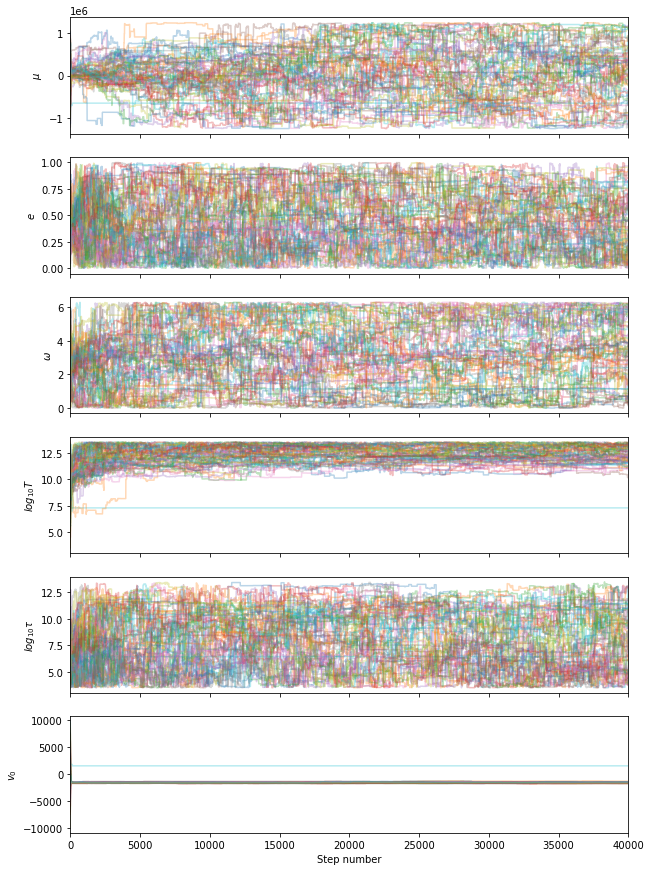

In [47]:
no_planet.trace()

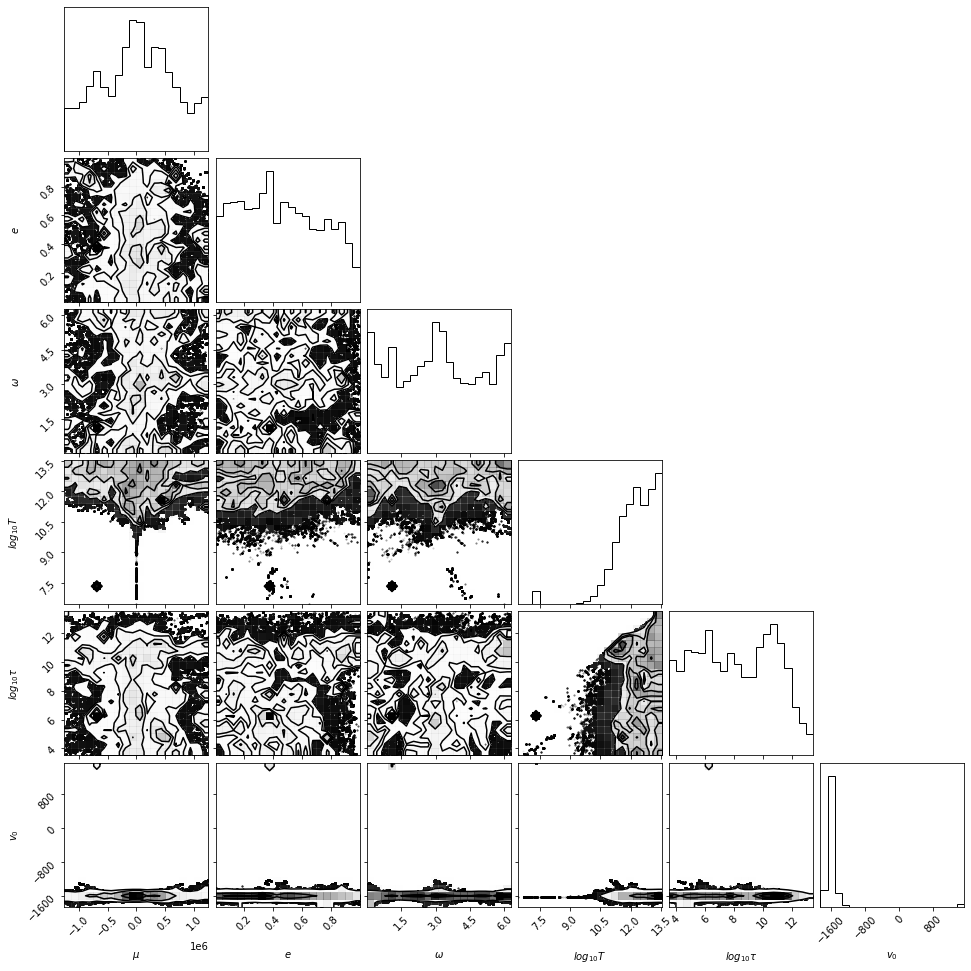

In [48]:
no_planet.corner()

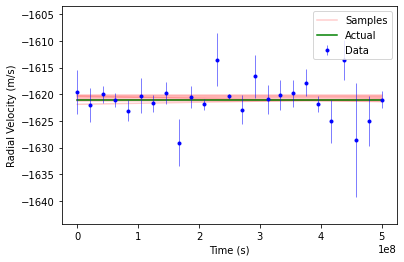

In [49]:
no_planet.plot_samples(10, real=True)

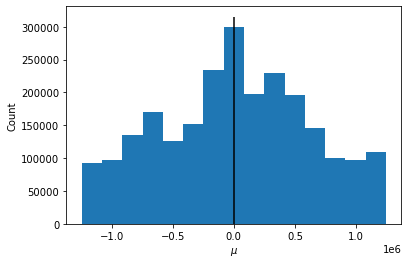

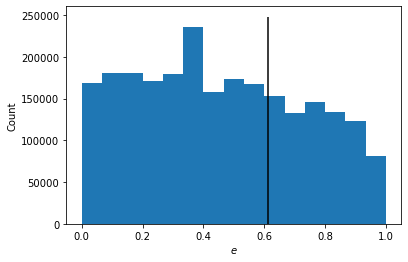

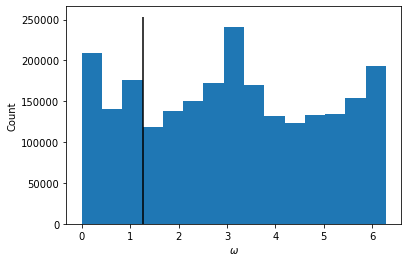

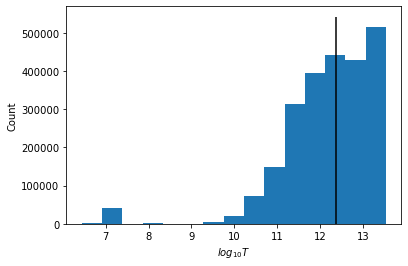

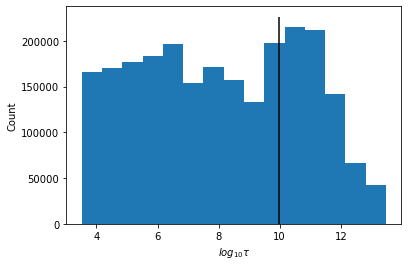

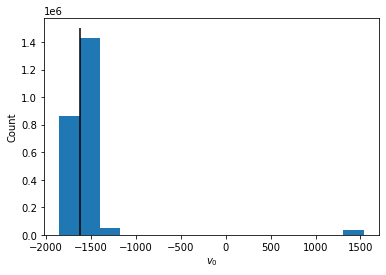

In [51]:
for i in range(len(no_planet.truth())):
    no_planet.param_hist_plot(i, bins=15, actual_value=no_planet.truth()[i])

## $e=0$

In [65]:
parameters = [np.random.choice(np.linspace(-1.246059e6, 1.246059e6, 20000))]
parameters.append(0)
parameters.append(np.random.uniform(0, np.pi/2))
parameters.append(10**np.random.uniform(3.516184928, 13.54019929)) # in seconds
parameters.append(10**np.random.uniform(3.516184928, np.log10(parameters[-1]))) # in seconds
parameters.append(np.random.choice(np.linspace(-9000, 9000, 10000))) # in m/s

sin_wave = BinarySystem(parameters=parameters, num_points=25, tmax=5e8)

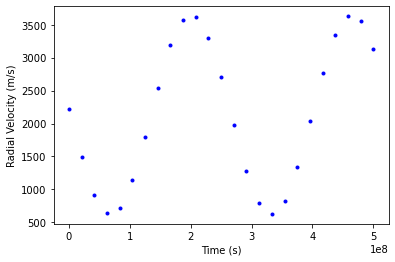

In [73]:
sin_wave.plot_data()

In [74]:
sin_wave.truth()

array([9.66803215e+05, 0.00000000e+00, 1.53535525e+00, 8.42162737e+00,
       5.95001241e+00, 2.13591359e+03])

In [75]:
sin_wave.initialize_mcmc(60)
sin_wave.run_mcmc(40000)

100%|██████████| 40000/40000 [10:15<00:00, 65.02it/s]


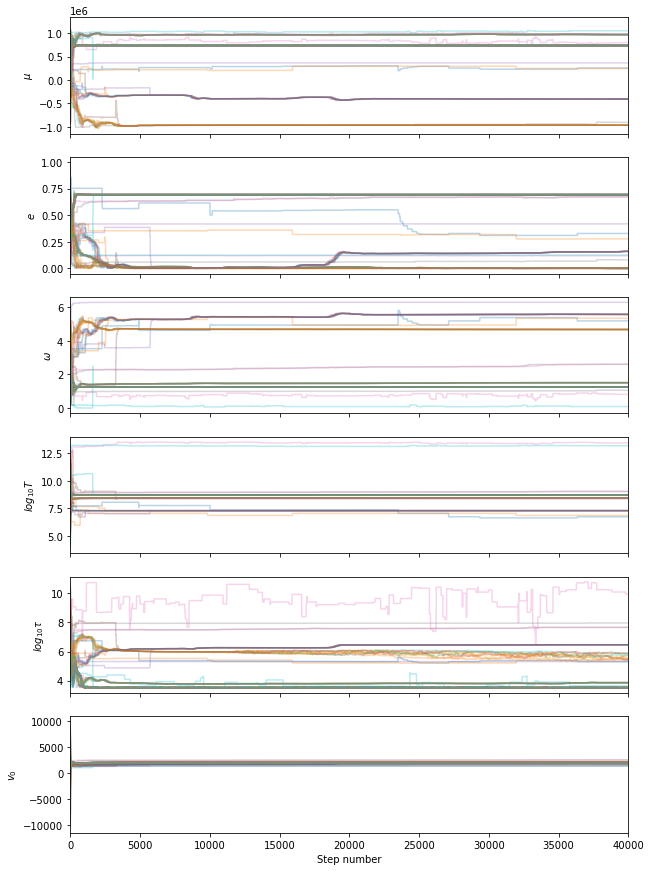

In [76]:
sin_wave.trace()

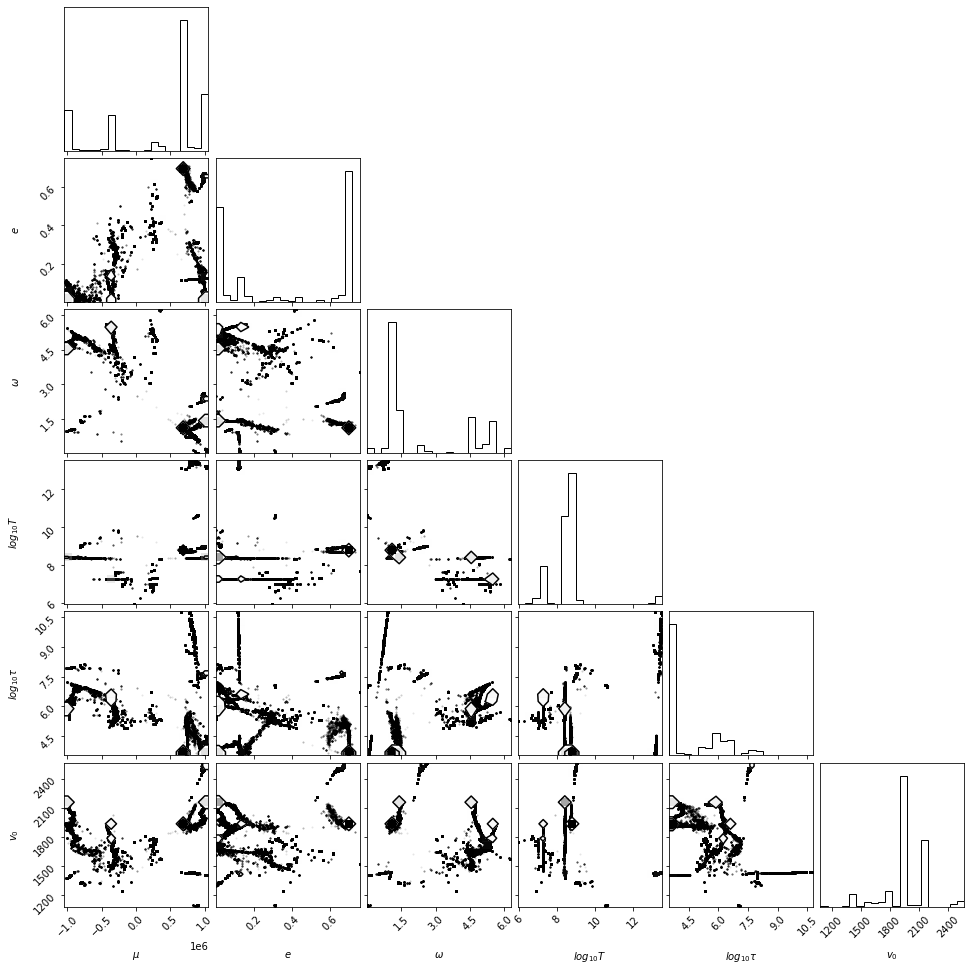

In [77]:
sin_wave.corner()

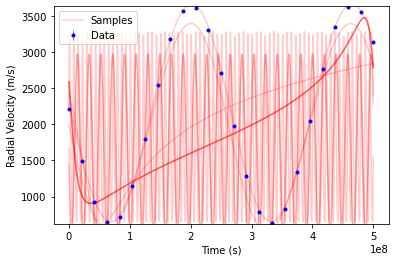

In [80]:
sin_wave.plot_samples(10)

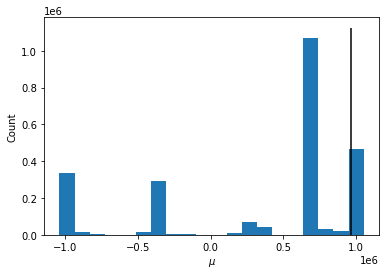

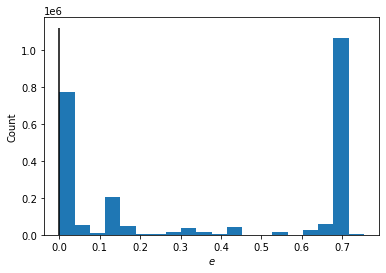

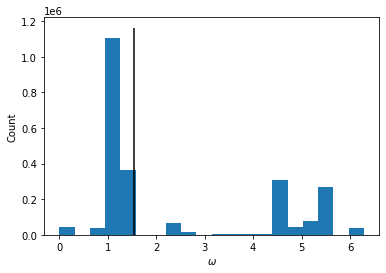

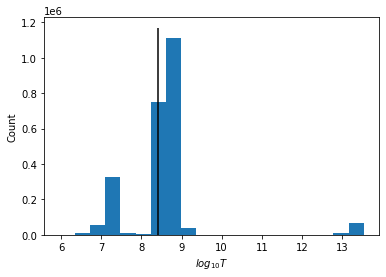

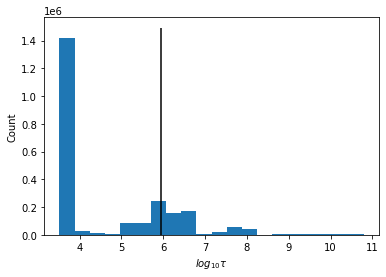

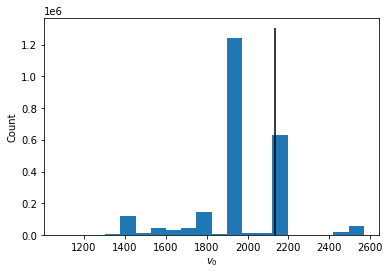

In [79]:
for i in range(len(sin_wave.truth())):
    sin_wave.param_hist_plot(i, 20, actual_value=sin_wave.truth()[i])